<img src="files/Northwind_ERD_updated.png">

**Research question 1:** Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

In [1]:
import pandas as pd
import sqlite3
import numpy as np
from functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

In [2]:
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

In [3]:
df = get_table(table='OrderDetail')

In [4]:
inspect_dataframe(df)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


None

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [5]:
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [6]:
# cur.execute("""SELECT * from OrderDetail""")

# df = pd.DataFrame(cur.fetchall())
# df.columns = [x[0] for x in cur.description]

# print(len(df))
# df.head()

In [7]:
discount_rates = set(df.Discount.values)

In [8]:
# avg_order_size = []
# for d in discount_rates:
#     mu = df[df['Discount'] == d]['Quantity'].mean()
#     avg_order_size.append(mu)
    
# avg_order_size

In [9]:
avg_discount_order_size = {}

for d in discount_rates: 
    avg_discount_order_size[d] = df[df['Discount'] == d]['Quantity'].mean()
    
avg_discount_order_size

{0.0: 21.715261958997722,
 0.25: 28.24025974025974,
 0.2: 27.024844720496894,
 0.05: 28.01081081081081,
 0.15: 28.38216560509554,
 0.1: 25.23699421965318,
 0.03: 1.6666666666666667,
 0.06: 2.0,
 0.01: 2.0,
 0.04: 1.0,
 0.02: 2.0}

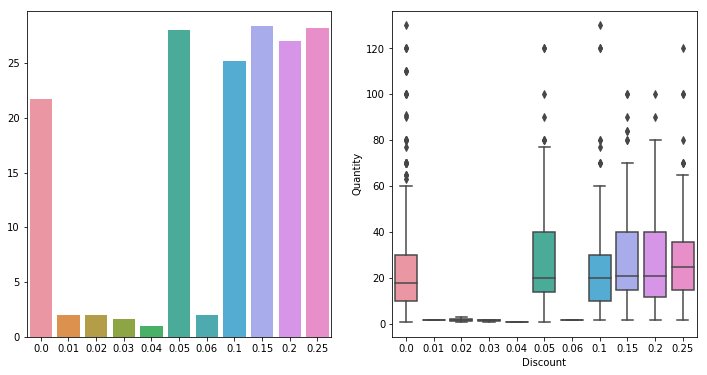

In [10]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

sns.barplot(x=list(avg_discount_order_size.keys()), y=list(avg_discount_order_size.values()), ax=ax1)
sns.boxplot(x=df.Discount, y=df.Quantity, data=df, ax=ax2)
plt.show()

**Record initial observations**

In [11]:
# df.ProductId.nunique()

In [12]:
# df.OrderId.nunique()

In [13]:
# len(df.OrderId)

**Does discount have an effect on order size? Break data into 2 groups: discount and no-discount**

In [14]:
no_d = np.array(df[df['Discount'] == 0.0]['Quantity'])
d = np.array(df[df['Discount'] != 0.0]['Quantity'])

In [15]:
compare_2(no_d,d)

The size of group1 is: 1317  	  The size of group2 is 838
The mean of group1 is: 21.715261958997722 	  The mean of group2 is: 27.10978520286396
The std of group1 is: 17.500845477669806 	  The std of group2 is: 20.759042075141373


* record some observations

visually inspect

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


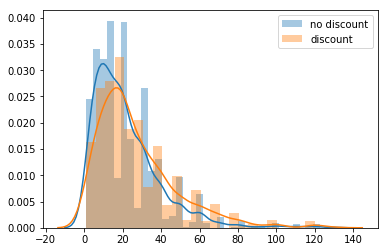

In [16]:
sns.distplot(no_d, label='no discount')
sns.distplot(d, label='discount')
plt.legend()

We've given it a good look, reiterate observations and make some hypotheses

**Null Hypothesis (H0): There is no relationship between discount and quantity ordered**

**Alternative Hypothesis (Ha): There is a positive relationship between discount and quantity ordered - a discount is likely to result in a larger order**

To ensure we have a stisitcally significant effect we'll get for a 95% level of confidence, and set **alpha to .05**

In [17]:
alpha=.05

In order to accept or reject H0 we will conduct a statistical test to see if the quantities ordered with a discount are statistically significantly greater than our baseline orders, or, orders with no discount. 

We can test our hypothesis with a one-sided t-test. Both of our groups of data are independent of one another, that is to say that quantity ordered per order in one group should not be affected by quantity ordered in the other. Therefore we will do an independent t-test with. 

But, first we must check our assumptions of normality for each group to determine if we need to sample. We'll do this with the shapiro-wilke test for normality. 

In [18]:
test_normality(d)
test_normality(no_d)

p = 6.88120409395894e-26 	 Therefore the data is not normal
p = 3.803856556577728e-34 	 Therefore the data is not normal


False

It looks like our data are not normally distributed. We'll need to sample from them to see if we can arrive at a more normal distribution to run our tests on. Let's draw those samples and test for normality again. 

In [19]:
no_discount_sample = random_sample(no_d)
discount_sample = random_sample(d)

test_normality(no_discount_sample)
test_normality(discount_sample)

p = 0.33265337347984314 	 Therefore the data is normal
p = 0.4230861961841583 	 Therefore the data is normal


True

Awesome, it looks like the Central Limit Theorem wins again! By drawing a series of random samples and obtaining their means we have identified a more normally distributed set of data. We can now move forward and check our variance assumption next, but first let's get a quick visual representation of our data now.   

/Users/rab/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


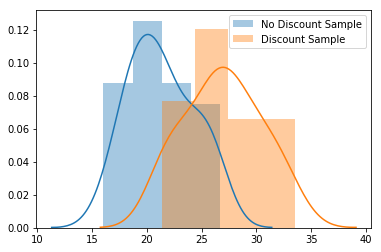

In [20]:
sns.distplot(no_discount_sample, label='No Discount Sample')
sns.distplot(discount_sample, label='Discount Sample')
plt.legend()

Now let's check to see if we have equal variance among our sample groups, that will determine which type of t-test we should perform. We'll do this using Levene's test for equal variance. 

In [21]:
test_variance(no_discount_sample, discount_sample)

p = 0.40489784596808087 	 Therefore the data has equal variances


True

Our samples have sufficiently equal variance, we'll therefore use the Student's T-Test to compare the two groups. We'll be looking for a p-value of less than .05 if we want to reject our null hypothesis.  

In [22]:
p = stats.ttest_ind(no_discount_sample, discount_sample, axis=0, equal_var=True)[1]

check_null_hypothesis(p,alpha=alpha)

With a p-value of 7.823861112619785e-09, which is less than 0.05 we can reject the H0 and accept Ha


False

It appears that for now we can reject the null hypothesis and conclude that there is a statistically significant and positive difference between quantities ordered with a discount than without a discount. There is a very low probability of a type 1 error, meaning that our results are due to random chance and that there is in fact not a positive effect on order size with a discount. 

In order to ensure that our results are as accurate as possible we can check the effect and power of our conclusions.

In [23]:
# check effect size with cohen's d
discount_effect = cohen_d(no_discount_sample, discount_sample)
discount_effect

1.7715370964411894

This is a fairly large effect size, reinforcing our conclusion to reject H0. We can use effect size to check the statistical power of our results as well. Here we will be looking for a power larger than .8, which tells us that our number of observations were large enough to draw our conclusions from at this level of alpha. 

In [24]:
from statsmodels.stats.power import TTestIndPower
power = TTestIndPower()

In [25]:
power.solve_power(effect_size=discount_effect, nobs1=len(discount_sample), alpha=alpha, alternative='larger')

0.9999999999965842

We have the power! It looks like our sample size is sufficiently big enough to detect an effect given our degree of confidence as set by alpha. 

With this, we can again affirm our conclusion to reject H0 and determine that discounts do indeed have a positive effect on quantity ordered. 

We can now move on to answering the second part of our question, which discount rates in fact have and effect on quantities ordered? First we can check to see if there is a significant difference among rates by conducting an ANOVA analysis. 

In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'Quantity ~ C(Discount)'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(Discount),21258.403604,10.0,6.011811,4.704231e-09
Residual,758141.232591,2144.0,NaN,NaN


With a very low p-value (4.7 e-09) we can conclude that there is in fact a difference among discount rates. Let's check the levels of significance for each category of discount. 

In [27]:
lm.pvalues

Intercept              6.746766e-281
C(Discount)[T.0.01]     2.947414e-01
C(Discount)[T.0.02]     1.385988e-01
C(Discount)[T.0.03]     6.524250e-02
C(Discount)[T.0.04]     2.709368e-01
C(Discount)[T.0.05]     2.095341e-05
C(Discount)[T.0.06]     2.947414e-01
C(Discount)[T.0.1]      2.065861e-02
C(Discount)[T.0.15]     2.789428e-05
C(Discount)[T.0.2]      7.326710e-04
C(Discount)[T.0.25]     4.781032e-05
dtype: float64

Recalling from our earlier value counts that there were very few observations for rates from 0.01-0.04, and only one for 0.06, we can disregard those as we do not have a large enough sample to determine statistical significance.

That leaves us with .05, .1, .15, .2 and .25. each of which appear to have a low enough p-value to suggest further analysis. 

To do this we will do post hoc t-tests with the Bonferroni correction. We will sample each group as before and compare them to the control sample (no discount). 

First, lets establish our new level of alpha by applying Bonferroni. 

In [28]:
b_alpha = bonferroni_alpha(obs=5, alpha=alpha)
b_alpha

0.01

Now we will need to create sample for each of our discount levels and test for normality and variance

In [29]:
five_sample = random_sample(df[df['Discount'] == .05]['Quantity'])
ten_sample = random_sample(df[df['Discount'] == .1]['Quantity'])
fifteen_sample = random_sample(df[df['Discount'] == .15]['Quantity'])
twenty_sample = random_sample(df[df['Discount'] == .2]['Quantity'])
twentyfive_sample = random_sample(df[df['Discount'] == .25]['Quantity'])


samples = [five_sample, ten_sample, fifteen_sample, twenty_sample, twentyfive_sample]

for s in samples:
    test_normality(s)

print('\n')    

for s in samples:
    test_variance(s, no_discount_sample)

p = 0.2579977214336395 	 Therefore the data is normal
p = 0.12009194493293762 	 Therefore the data is normal
p = 0.5717858672142029 	 Therefore the data is normal
p = 0.06037963926792145 	 Therefore the data is normal
p = 0.14139986038208008 	 Therefore the data is normal


p = 0.061491881116566276 	 Therefore the data has equal variances
p = 0.04064757160025287 	 Therefore the data do not have equal variances
p = 0.22426671989995972 	 Therefore the data has equal variances
p = 0.10079908494523461 	 Therefore the data has equal variances
p = 0.7181557872077486 	 Therefore the data has equal variances


By sampling for each discount level we've satisfied our normality and variance assumptions, now we can conduct t-tests with our new confidence level set by the Bonferroni Correction, and check for effect sizes and power levels as well. 

In [30]:
for s in samples:
    p = stats.ttest_ind(no_discount_sample, s, axis=0, equal_var=True)[1]
    check_null_hypothesis(p, alpha=b_alpha)

With a p-value of 1.2503099412481145e-10, which is less than 0.01 we can reject the H0 and accept Ha
With a p-value of 0.00013137071140736036, which is less than 0.01 we can reject the H0 and accept Ha
With a p-value of 1.0691460046827256e-09, which is less than 0.01 we can reject the H0 and accept Ha
With a p-value of 7.408910208503141e-08, which is less than 0.01 we can reject the H0 and accept Ha
With a p-value of 6.02162879322284e-11, which is less than 0.01 we can reject the H0 and accept Ha


In [33]:
for s in samples:
    print(cohen_d(no_discount_sample,s))

2.052379522366507
1.0760681446998257
1.9067404476232637
1.6177367785852022
2.102057782143697


In [32]:
cohen_d(no_discount_sample, five_sample)

2.052379522366507